## 变分自编码器简洁实现

例子: MNIST 数据集图片训练

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils import data
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torchvision.utils import save_image
import os
import time
import numpy as np
from itertools import cycle

### 加载数据集

In [2]:
def load_data_mnist(batch_size, resize=None):
    """下载MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=0),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=0))

### 定义网络结构

In [3]:
class Variable_AutoEncoder(nn.Module):
    def __init__(self):
        super(Variable_AutoEncoder, self).__init__()

        # 定义编码器
        self.Encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )

        # 定义解码器
        self.Decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

        self.fc_mean = nn.Linear(400, 20)  # 均值
        self.fc_sigma = nn.Linear(400, 20) # 标准差

    def forward(self, input):
        # 展平
        code = input.view(input.size(0), -1)

        # 放入编码器
        code = self.Encoder(code)

        # 求均值和标准差 
        mean = self.fc_mean(code)
        sigma = self.fc_sigma(code)

        # 使用均值和标准差生成隐变量c        
        e = torch.randn_like(sigma)
        c = torch.exp(sigma) * e + mean

        # 放入解码器
        output = self.Decoder(c)

        output = output.view(input.size(0), 1, 28, 28)
        return output, mean, sigma


In [4]:
net = Variable_AutoEncoder()
net = net.cuda()

### 定义作图工具

In [5]:
def draw(title, xlabel, ylabel, x, y):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y, 'r')
    plt.show()

### 定义训练函数

In [6]:
# 生成图片的存储位置
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [7]:
def train_epoch_mlp(net, train_iter, loss, updater):
    """训练模型的一个迭代周期""" 
    # 要返回的损失
    l, BCE, KLD, X_hat = 0, 0, 0, 0

    # 将模型调整成训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练精准度总和、样本数
    updater.zero_grad()
    for X, _ in train_iter:
        X  = X.cuda()
        X_hat, mean, sigma = net(X)
        l, BCE, KLD = loss(X_hat, X, mean, sigma)
        l.mean().backward()
        updater.step()

    # 返回重构损失和KL散度
    return l, BCE, KLD

In [8]:
def train_mlp(net, train_iter, test_iter, loss, num_epochs, updater):
    test_iter = cycle(iter(test_iter))
    loss_list = []
    BCE_list = []
    KLD_list = []

    for epoch in range(num_epochs):
        l, BCE, KLD = train_epoch_mlp(net, train_iter, loss, updater)
        l = l.cpu().detach().numpy()
        BCE = BCE.cpu().detach().numpy()
        KLD = KLD.cpu().detach().numpy()
        loss_list.append(l)
        BCE_list.append(BCE)
        KLD_list.append(KLD)

        # 显示1张生成结果
        X, _ = next(test_iter)
        X = X.cuda()
        X_hat, _1, _2 = net(X)
        save_image(X_hat, os.path.join(sample_dir, f'epoch-{epoch}.png'))


    epochlist = range(1, num_epochs + 1)
    draw('loss_list', 'epochs', 'loss', epochlist, loss_list)
    draw('BCE_list', 'epochs', 'BCE', epochlist, BCE_list)
    draw('KLD_list', 'epochs', 'KLD', epochlist, KLD_list)

### 进行训练

In [9]:
def loss_function(x_hat, x, mu, sigma):
    # 1. the reconstruction loss.
    BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')

    # 2. KL-divergence
    KLD = 0.5 * torch.sum(torch.exp(sigma) + torch.pow(mu, 2) - 1. - sigma)

    # 3. total loss
    loss = BCE + KLD

    return loss, BCE, KLD

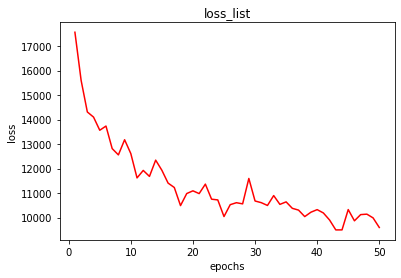

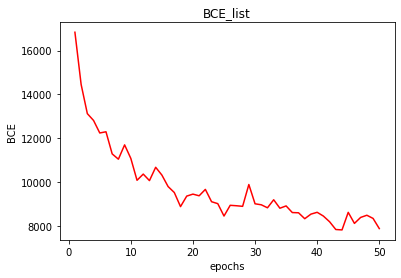

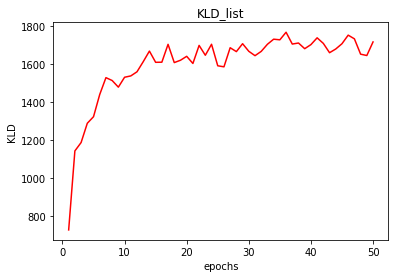

In [10]:
batch_size, lr, num_epochs = 256, 0.001, 50
loss = loss_function    

# 可自动进行学习率的调整
trainer = torch.optim.Adagrad(net.parameters(), lr=lr)

train_iter, test_iter = load_data_mnist(batch_size)
train_mlp(net, train_iter, test_iter, loss, num_epochs, trainer)